# mdb_to_df

In [1]:
import pyodbc
import os
import pandas as pd
from zipfile import ZipFile


def mdb_to_df(file_name, sql):

    conn_str = (
        r'DRIVER={Microsoft Access Driver (*.mdb, *.accdb)};'
        fr'DBQ={file_name};'
    )
    print(conn_str)
    cnxn = pyodbc.connect(conn_str)

    df = pd.read_sql(sql, cnxn)

    print(f'{file_name} Loaded')
    return df


# Cascade

In [2]:
# Determine alarms real periods
def cascade(df):

    df.reset_index(inplace=True, drop=True)
    df['TimeOffMax'] = df.TimeOff.cummax().shift()

    df.at[0, 'TimeOffMax'] = df.at[0, 'TimeOn']

    return df


# looping through turbines and applying cascade method
def apply_cascade(result_sum):

    # Sort by alarm ID
    result_sum.sort_values(['ID'], inplace=True)
    df = result_sum.groupby('StationId').apply(cascade)

    mask_root = (df.TimeOn.values >= df.TimeOffMax.values)
    mask_children = (df.TimeOn.values < df.TimeOffMax.values) & (
        df.TimeOff.values > df.TimeOffMax.values)
    mask_embedded = (df.TimeOff.values <= df.TimeOffMax.values)

    df.loc[mask_root, 'NewTimeOn'] = df.loc[mask_root, 'TimeOn']
    df.loc[mask_children, 'NewTimeOn'] = df.loc[mask_children, 'TimeOffMax']
    df.loc[mask_embedded, 'NewTimeOn'] = df.loc[mask_embedded, 'TimeOff']

    df.drop(columns=['TimeOffMax'], inplace=True)

    df.reset_index(inplace=True, drop=True)

    TimeOff = df.TimeOff
    NewTimeOn = df.NewTimeOn

    df['RealPeriod'] = abs(TimeOff - NewTimeOn)

    mask_siemens = (df['Error Type'] == 1)
    mask_tarec = (df['Error Type'] == 0)

    df['Period Siemens(s)'] = df[mask_siemens].RealPeriod  # .dt.seconds
    df['Period Tarec(s)'] = df[mask_tarec].RealPeriod  # .dt.seconds
    # df['RealPeriod'] = df['RealPeriod'].dt.seconds

    return df


# Read SUM

In [3]:
import numpy as np
from datetime import datetime as dt


def read_sum(period):
    usecols_sum = """
    SELECT CDbl(TimeOn) AS TOn, CDbl(TimeOff) AS TOff,
    StationNr, Alarmcode, ID, Parameter
    FROM tblAlarmLog WHERE TimeOff IS NOT NULL
    union
    SELECT CDbl(TimeOn) AS TOn, TimeOff AS TOff,
    StationNr, Alarmcode, ID, Parameter
    FROM tblAlarmLog WHERE TimeOff IS NULL
    """
    file_name = f'../DATA/SUM/{period}-sum.mdb'
    alarms = mdb_to_df(file_name=file_name, sql=usecols_sum)

    alarms['TOn'] = sqldate_to_datetime(alarms['TOn'])
    alarms['TOff'] = sqldate_to_datetime(alarms['TOff'])

    alarms.rename(columns={'TOn': 'TimeOn',
                           'TOff': 'TimeOff'}, inplace=True)

    alarms = alarms[alarms.StationNr >= 2307405]

    alarms = alarms[
        alarms.StationNr <= 2307535].reset_index(
        drop=True)

    alarms.dropna(subset=['Alarmcode'], inplace=True)

    alarms.reset_index(drop=True, inplace=True)

    alarms.Alarmcode = alarms.Alarmcode.astype(int)

    return alarms


def sqldate_to_datetime(column):
    try:
        column = column.str.replace(',', '.').astype(float)
    except:
        pass
    day_parts = np.modf(column.loc[~column.isna()])
    column = column.fillna(0)

    column.loc[~column.isna()] = (
        dt(1899, 12, 30) +
        day_parts[1].astype('timedelta64[D]', errors='ignore') +
        (day_parts[0] * 86400000).astype('timedelta64[ms]', errors='ignore')
    )
    return column


# Input MTBF MTTR MTTI 

In [38]:
from dateutil.relativedelta import relativedelta

period = '2020-07'

period_dt = dt.strptime(period, "%Y-%m")
period_month = period_dt.month
period_year = period_dt.year

days_in_period = pd.Period(f'{period}').days_in_month

previous_period_dt = period_dt + relativedelta(months=-1)
previous_period = previous_period_dt.strftime("%Y-%m")

lastday_period_dt = period_dt + relativedelta(months=1, days=-1)
lastday_period = lastday_period_dt.strftime("%Y-%m-%d")


lastday_previous_period_dt = period_dt + relativedelta(days=-1)
lastday_previous_period = lastday_previous_period_dt.strftime("%Y-%m-%d")

days_to_previous_period = len(pd.date_range(f'{period_year}-01-01', lastday_previous_period_dt))


In [39]:
MTTI = pd.read_html(f'./input/{period}/Analyse_ID-173_MTTI.html', header=0)[0]
MTTI

,StationNr,StationCount,MTTI en (s),Nombre de valeurs,Somme des valeurs,Nombre d'erreurs
0,2307405,1.0,NaN,NaN,NaN,NaN
1,2307406,2.0,49614.0,1.0,49614.0,0.0
2,2307407,3.0,NaN,NaN,NaN,NaN
3,2307408,4.0,60897.0,1.0,60897.0,0.0
4,2307409,5.0,34306.0,2.0,68612.0,0.0
...,...,...,...,...,...,...
127,2307532,128.0,19.0,1.0,19.0,0.0
128,2307533,129.0,NaN,NaN,NaN,NaN
129,2307534,130.0,NaN,NaN,NaN,NaN
130,2307535,131.0,39606.0,2.0,79212.0,0.0


In [40]:
MTTI_period = MTTI.iat[-1,2]/3600
MTTI_period

7.875

In [7]:
(97.32*days_to_previous_period + 98.38*days_in_period)/(days_to_previous_period+days_in_period)

97.47427230046947

In [8]:
# MTTI cumulé

last_mtti_cumul = float(input('last_mtti_cumul') or 8.12)

mtti_cumul = (last_mtti_cumul*days_to_previous_period + MTTI_period*days_in_period)/(days_to_previous_period+days_in_period)

f'({last_mtti_cumul}*{days_to_previous_period} + {MTTI_period}*{days_in_period})/({days_to_previous_period}+{days_in_period})'

'(8.12*182 + 7.875*31)/(182+31)'

In [42]:
MTBF_MTTR_cat_prev_cumul = pd.read_excel(f'./input/{previous_period}/MTBF & MTTR cumul.xlsx')

MTBF_MTTR_cat_prev_cumul.dropna(how='all', subset=['MTBF en j', 'MTTR en h'],inplace=True)

MTBF_MTTR_cat_prev_cumul.rename(columns={'Catégorie Alarme': 'Catégorie'}, inplace=True)

MTBF_MTTR_cat_prev_cumul

,Catégorie,Durée Alarme,Fréquence Alarme,MTTR en h,MTBF en j
0,System,1727.498056,185,9.337827,128.486600
1,Generator,307.007778,9,34.111975,2647.689779
2,Hub,454.496944,37,12.283701,643.866557
3,Gear,548.919167,45,12.198204,529.313964
4,Grid,1426.620833,161,8.860999,147.717748
5,Rotor,154.212778,18,8.567377,1324.198582
6,Hydraulics,1939.796667,186,10.429014,127.748253
7,Environment,124.631667,21,5.934841,1135.086048
9,Brake,350.368333,35,10.010524,680.782895
10,Yaw,2863.508333,252,11.363128,94.137647


In [43]:
MTBF_MTTR_cat = pd.read_excel(f'./input/{period}/MTBF & MTTR.xlsx')

MTBF_MTTR_GLOBAL, MTBF_MTTR_cat = MTBF_MTTR_cat.iloc[0], MTBF_MTTR_cat.iloc[1:]

MTBF_MTTR_cat.dropna(how='all', subset=['MTBF', 'MTTR'], inplace=True)

In [44]:
MTBF_MTTR_GLOBAL

Catégorie                    <GLOBAL>
MTBF                        4.188e+06
MTBF (Temps total)         3.5087e+08
MTBF (Temps d'arrêt)      3.26645e+06
MTBF (Nombre d'arrêts)             83
MTTR                          39354.8
MTTR (Temps d'arrêt)      3.26645e+06
MTTR (Nombre d'arrêts)             83
Name: 0, dtype: object

In [12]:
MTBF_MTTR_cat_cumul = MTBF_MTTR_cat.merge(MTBF_MTTR_cat_prev_cumul, on=['Catégorie'], how='outer').fillna(0)
MTBF_MTTR_cat_cumul

,Catégorie,MTBF,MTBF (Temps total),MTBF (Temps d'arrêt),MTBF (Nombre d'arrêts),MTTR,MTTR (Temps d'arrêt),MTTR (Nombre d'arrêts),Durée Alarme,Fréquence Alarme,MTTR en h,MTBF en j
0,Brake,8.767718e+07,350870400.0,161696.0,4.0,40424.0000,161696.0,4.0,350.368333,35,10.010524,680.782895
1,Controller,4.380744e+07,350870400.0,410892.0,8.0,51361.5000,410892.0,8.0,1771.196389,152,11.652608,156.369738
2,Converter,1.750276e+07,350870400.0,815134.0,20.0,40756.7000,815134.0,20.0,1157.399167,95,12.183149,250.460790
3,Gear,3.896020e+07,350870400.0,228639.0,9.0,25404.3333,228639.0,9.0,548.919167,45,12.198204,529.313964
4,Grid,2.919987e+07,350870400.0,471961.0,12.0,39330.0833,471961.0,12.0,1426.620833,161,8.860999,147.717748
5,Hub,5.009759e+07,350870400.0,187270.0,7.0,26752.8571,187270.0,7.0,454.496944,37,12.283701,643.866557
6,Hydraulics,3.896579e+07,350870400.0,178324.0,9.0,19813.7777,178324.0,9.0,1939.796667,186,10.429014,127.748253
7,Miscellaneous,3.507746e+08,350870400.0,95773.0,1.0,95773.0000,95773.0,1.0,3.450000,1,3.450000,23841.856250
8,Rotor,1.754211e+08,350870400.0,28157.0,2.0,14078.5000,28157.0,2.0,154.212778,18,8.567377,1324.198582
9,System,2.335240e+07,350870400.0,584336.0,15.0,38955.7333,584336.0,15.0,1727.498056,185,9.337827,128.486600


In [14]:
# Generate the new calculated MTTBF and MTTR for each error group

temps_total_cumul = len(pd.date_range(f'{period_year}-01-01', f'{lastday_period}', freq='D'))*24*131

duree_cumul = MTBF_MTTR_cat_cumul['Durée Alarme'] + MTBF_MTTR_cat_cumul['MTBF (Temps d\'arrêt)']/3600

MTBF_MTTR_cat_cumul['Durée Alarme'] = duree_cumul

freq_cumul = MTBF_MTTR_cat_cumul['MTBF (Nombre d\'arrêts)'] + MTBF_MTTR_cat_cumul['Fréquence Alarme']

MTBF_MTTR_cat_cumul['Fréquence Alarme'] = freq_cumul

MTBF_MTTR_cat_cumul['MTBF en j'] = (temps_total_cumul - duree_cumul) / (freq_cumul * 24)

MTBF_MTTR_cat_cumul['MTTR en h'] = duree_cumul/freq_cumul

In [15]:
df_ax4 =  MTBF_MTTR_cat_cumul[['Catégorie', 'MTTR en h', 'MTBF en j']]

df_ax4.rename(columns={'MTTR en h': 'MTTR', 'MTBF en j': 'MTBF'}, inplace=True)

In [16]:
MTBF_MTTR_cat_current_cumul = MTBF_MTTR_cat_cumul[['Catégorie', 'Durée Alarme', 'Fréquence Alarme', 'MTTR en h', 'MTBF en j']]

MTBF_MTTR_cat_current_cumul.to_excel(f'./input/{period}/MTBF & MTTR cumul.xlsx')

In [78]:
duree_period = MTBF_MTTR_GLOBAL['MTBF (Temps d\'arrêt)']/3600

freq_period = MTBF_MTTR_GLOBAL['MTBF (Nombre d\'arrêts)']

mtbf_period = (days_in_period*24*131 - duree_period) / freq_period /24
mttr_period = duree_period/freq_period

In [82]:
last_mtbf_cumulee = float(input('last_mtbf_cumulee') or 37.718)
last_mttr_cumulee = float(input('last_mttr_cumulee') or 11.2)


mtbf_cumul = (last_mtbf_cumulee*days_to_previous_period + mtbf_period*days_in_period)/(days_to_previous_period+days_in_period)

mttr_cumul = (last_mttr_cumulee*days_to_previous_period + mttr_period*days_in_period)/(days_to_previous_period+days_in_period)

(mtbf_cumul, mttr_cumul)


(39.283167497978354, 11.160979426312448)

# Calcul mois

In [139]:
alarms = read_sum(period)

results = pd.read_pickle(f'../DATA/results/{period}.pkl')

alarms.rename(columns={'StationNr': 'StationId'}, inplace=True)

alarms['StationId'] = alarms['StationId'] - 2307404
results['StationId'] = results['StationId'] - 2307404

DRIVER={Microsoft Access Driver (*.mdb, *.accdb)};DBQ=../DATA/SUM/2020-07-sum.mdb;
../DATA/SUM/2020-07-sum.mdb Loaded


In [49]:
results

,Unnamed: 0,StationId,TimeStamp,RealPeriod,Period 0(s),Period 1(s),UK Text,wtc_kWG1Tot_accum,wtc_kWG1TotE_accum,wtc_ActPower_min,...,EL 20-25,EL_115_left,EL_indefini,EL_wind,Duration lowind(s),EL_wind_start,Duration lowind_start(s),EL_alarm_start,Duration alarm_start(s),EL_indefini_left
0,0,1,2020-07-01 00:10:00,0.0,0.0,0.0,0,396.0,396.0,2236.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,1,2020-07-01 00:20:00,0.0,0.0,0.0,0,359.0,359.0,1381.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,1,2020-07-01 00:30:00,0.0,0.0,0.0,0,380.0,380.0,1357.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,1,2020-07-01 00:40:00,0.0,0.0,0.0,0,347.0,347.0,1374.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,1,2020-07-01 00:50:00,0.0,0.0,0.0,0,356.0,355.0,1365.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
584779,584779,131,2020-07-31 23:20:00,0.0,0.0,0.0,0,95.0,95.0,331.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
584780,584780,131,2020-07-31 23:30:00,0.0,0.0,0.0,0,109.0,109.0,331.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
584781,584781,131,2020-07-31 23:40:00,0.0,0.0,0.0,0,128.0,128.0,479.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
584782,584782,131,2020-07-31 23:50:00,0.0,0.0,0.0,0,112.0,112.0,453.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [50]:
Frame = pd.DataFrame
c1 = 'Alarmcode'
c2 = 'Error Group'

error_group = pd.concat([Frame({c1: range(901, 2101), c2: 'System'}),
                         Frame({c1: range(2101, 3000), c2: 'Generator'}),
                         Frame({c1: range(3100, 4000), c2: 'Hub'}),
                         Frame({c1: range(4100, 5000), c2: 'Gear'}),
                         Frame({c1: range(5000, 6000), c2: 'Grid'}),
                         Frame({c1: range(6100, 7000), c2: 'Rotor'}),
                         Frame({c1: range(7100, 8000), c2: 'Hydraulics'}),
                         Frame({c1: range(8000, 8400), c2: 'Environement'}),
                         Frame({c1: range(8450, 9000),
                                c2: 'Turbine cond...'}),
                         Frame({c1: range(9100, 10000), c2: 'Brake'}),
                         Frame({c1: range(10100, 11000), c2: 'Yaw'}),
                         Frame({c1: range(11100, 12000), c2: 'PFC'}),
                         Frame({c1: range(12100, 13000), c2: 'Transformer'}),
                         Frame({c1: range(13000, 14000), c2: 'Converter-1'}),
                         Frame({c1: range(14000, 15000), c2: 'Gen.inverter'}),
                         Frame({c1: range(15000, 16000), c2: 'Grid inverter'}),
                         Frame({c1: range(16000, 17000), c2: 'Main bearing'}),
                         Frame({c1: range(17000, 18300), c2: 'Converter-2'}),
                         Frame({c1: range(62001, 64000), c2: 'Controller'}),
                         Frame({c1: range(64000, 65200), c2: 'MISCELLANEOUS'})])


In [51]:
reorder = ['System',
           'Generator',
           'Hub',
           'Gear',
           'Grid',
           'Rotor',
           'Hydraulics',
           'Environement',
           'Turbine cond...',
           'Brake',
           'Yaw',
           'PFC',
           'Transformer',
           'Converter-1',
           'Gen.inverter',
           'Grid inverter',
           'Main bearing',
           'Converter-2',
           'Controller',
           'MISCELLANEOUS']

In [52]:
error_list = pd.read_excel(
    r'Error_Type_List_Las_Update_151209.xlsx',
    usecols=lambda x: x != 'Type Selected')

error_list.Alarmcode = error_list.Alarmcode.astype(int)  # ,errors='ignore'

error_list.drop_duplicates(subset=['Alarmcode'], inplace=True)

error_list = error_list.merge(error_group, on='Alarmcode', how='left')

# ------------------------------------------------------------------------
''' label scada alarms with coresponding error type
and only keep alarm codes in error list'''
result_sum = pd.merge(alarms, error_list,
                        on='Alarmcode',
                        how='inner', sort=False)

# Remove warnings
result_sum = result_sum.loc[result_sum['Error Type'].isin([1, 0])]

# apply cascade
alarms_result_sum = apply_cascade(result_sum)

# only keep  parent alarms
parent_result_sum = alarms_result_sum.query('TimeOn == NewTimeOn')

# dash duree
main_result_sum = alarms_result_sum.query('RealPeriod > @pd.Timedelta(0)')
# main_result_sum['ALL duree'] = main_result_sum['TimeOff'] -main_result_sum['TimeOn']

In [53]:
main_result_sum

,TimeOn,TimeOff,StationId,Alarmcode,ID,Parameter,UK Text,Error Type,Error Group,NewTimeOn,RealPeriod,Period Siemens(s),Period Tarec(s)
0,2020-07-02 08:57:20.999,2020-07-02 15:33:49.000,1,1001,3034936,...,Manual stop,1,System,2020-07-02 08:57:20.999,06:36:28.001000,06:36:28.001000,NaT
20,2020-07-05 01:45:53.000,2020-07-05 01:49:23.000,1,3130,3037604,...,Pitch lubrication,0,Hub,2020-07-05 01:45:53.000,00:03:30,NaT,00:03:30
21,2020-07-06 08:11:10.000,2020-07-06 15:18:53.999,1,1001,3040484,...,Manual stop,1,System,2020-07-06 08:11:10.000,07:07:43.999000,07:07:43.999000,NaT
50,2020-07-06 15:19:25.000,2020-07-06 15:19:30.000,1,9304,3042468,...,Brake pressure too high,1,Brake,2020-07-06 15:19:25.000,00:00:05,00:00:05,NaT
51,2020-07-06 15:19:31.000,2020-07-06 15:19:34.999,1,9304,3042471,...,Brake pressure too high,1,Brake,2020-07-06 15:19:31.000,00:00:03.999000,00:00:03.999000,NaT
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4911,2020-07-21 14:59:10.999,2020-07-21 15:20:05.000,131,1001,3069270,...,Manual stop,1,System,2020-07-21 15:06:40.999,00:13:24.001000,00:13:24.001000,NaT
4913,2020-07-21 15:20:11.999,2020-07-22 11:02:36.000,131,4200,3069337,...,Gearoilpump/blower superheated,1,Gear,2020-07-21 15:20:11.999,19:42:24.001000,19:42:24.001000,NaT
4915,2020-07-22 08:30:32.999,2020-07-22 14:42:45.999,131,1001,3070019,...,Manual stop,1,System,2020-07-22 11:02:36.000,03:40:09.999000,03:40:09.999000,NaT
4928,2020-07-22 14:42:40.000,2020-07-22 15:06:16.000,131,1025,3070470,...,Manual idle stop - yawing,1,System,2020-07-22 14:42:45.999,00:23:30.001000,00:23:30.001000,NaT


## Graphe 3 ax5

In [54]:
df_ax5 = (main_result_sum.groupby('Error Group')
                  .agg(Freq=('Alarmcode', 'count'),
                       Durée=('RealPeriod', lambda x: x.sum().total_seconds()/3600))
                  .reindex(reorder)
                  .dropna()
                  .reset_index()
                  )

# df_ax5.plot(kind='bar', x='Error Group', ax=ax5)

## Graphe 4 ax6

In [55]:
df_ax6 = (main_result_sum.groupby('Alarmcode')
                .agg(Freq=('Alarmcode', 'count'),
                     Durée=('RealPeriod',
                               lambda x: x.sum().total_seconds()/3600))
                .sort_values('Durée', ascending=False)
                .head(20)
                .reset_index()
                .sort_values('Durée', ascending=False))

# df_ax6.plot(kind='bar', x='Alarmcode', ax=ax6)


## Graph 6 ax9

In [56]:
df_ax9 = pd.merge(
        (results.groupby('StationId')
                       .agg(**{'Durée alarmes': ('Duration 115(s)', lambda x: x.sum()/3600),
                               'Durée autres': ('Duration 20-25(s)', lambda x: x.sum()/3600)})
                       .sort_values('Durée alarmes', ascending=False)
                 # .head(25)
                 .reset_index()
         ),
         (alarms.groupby('StationId')
                      .agg(**{'Freq alarmes': ('Alarmcode', lambda x: int(x[x == 115].count()/2)),
                              'Freq autres': ('Alarmcode', lambda x: x[x == 20].count())})
                      .reset_index()
         ),
         on='StationId'
        ).sort_values('Durée alarmes', ascending=False).head(20)


df_ax9['Duration_20_25 reel'] = df_ax9['Durée autres']
df_ax9['Durée autres'] = df_ax9['Duration_20_25 reel'] - df_ax9['Durée alarmes']
# df_ax9.plot(kind='bar', x='StationId', ax=ax9)

## Graphe 7 ax10

In [57]:
df_ax10 = (results[['StationId','ELNX', 'EL_indefini_left']]
                .groupby('StationId')
                .sum()
                .sort_values('ELNX', ascending=False)
                .head(20)
                .reset_index())

df_ax10 = round(df_ax10, 2).abs().head(20)
df_ax10['StationId'] = (df_ax10['StationId'] - 2307404  ).astype(int)

In [58]:
df_ax10.to_clipboard()

## table 1 ax1 row 2

In [59]:

df_ax1 = pd.DataFrame(columns=['LTA-Lost Time', 'Indispo. Total %','Indispo. Tarec %', 'Indispo. Siemens %', 'Indispo. ONEE %', 'Indispo. Ebop %',
                               'Pertes élctriques \n en MWh', 'Power Boost en MWh', 'Performance moyenne \n des turbines',
                               'MTBF - Mean Time \n Between Failure', 'MTTR - Mean Time \n To Repair', 'MTTI - Mean Time \n To Intervention'],
                     index=['Indicateurs \n annuels :', f'Indicateurs du \n mois {period} :'])
df_ax1 = df_ax1.fillna(0.)

In [60]:
df_ax1.iat[1, 1] = round(100*results['RealPeriod'].sum()/3600/24/131/31,2)
df_ax1.iat[1, 2] = round(100*results['Period 0(s)'].sum()/3600/24/131/31,2)
df_ax1.iat[1, 3] = round(100*results['Period 1(s)'].sum()/3600/24/131/31,2)

df_ax1.iat[1, 6] = round(results.wtc_ActPower_mean.sum()/6/1000 - onee_07_2020,2)

df_ax1.iat[1, 7] = (boost.groupby('TimeStamp').sum().iat[-1, -1] - boost.groupby('TimeStamp').sum().iat[0, 1])/1000

df_ax1.iat[1, 9]  = mtbf_period
df_ax1.iat[1, 10] = mttr_period
df_ax1.iat[1, 11] = MTTI_2020_07


# results.wtc_kWG1TotE_accum.sum() - results.wtc_kWG1Tot_accum.sum()
# results.wtc_ActPower_mean.sum()/6 - results.wtc_kWG1Tot_accum.sum()



NameError: name 'onee_07_2020' is not defined

In [61]:
MTT

NameError: name 'MTT' is not defined

In [62]:
df_ax1

,LTA-Lost Time,Indispo. Total %,Indispo. Tarec %,Indispo. Siemens %,Indispo. ONEE %,Indispo. Ebop %,Pertes élctriques \n en MWh,Power Boost en MWh,Performance moyenne \n des turbines,MTBF - Mean Time \n Between Failure,MTTR - Mean Time \n To Repair,MTTI - Mean Time \n To Intervention
Indicateurs \n annuels :,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Indicateurs du \n mois 2020-07 :,0.0,1.79,0.2,1.59,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [63]:
results.columns

Index(['Unnamed: 0', 'StationId', 'TimeStamp', 'RealPeriod', 'Period 0(s)',
       'Period 1(s)', 'UK Text', 'wtc_kWG1Tot_accum', 'wtc_kWG1TotE_accum',
       'wtc_ActPower_min', 'wtc_ActPower_max', 'wtc_ActPower_mean',
       'Duration 115(s)', 'Duration 20-25(s)', 'wtc_AcWindSp_mean',
       'wtc_ActualWindDirection_mean', '('met_WindSpeedRot_mean', 38)',
       '('met_WindSpeedRot_mean', 39)', '('met_WindSpeedRot_mean', 246)',
       '('met_WinddirectionRot_mean', 38)',
       '('met_WinddirectionRot_mean', 39)',
       '('met_WinddirectionRot_mean', 246)', 'Epot', 'Correction Factor',
       'Available Turbines', 'EL', 'ELX', 'ELNX', 'EL 115', 'EL 20-25',
       'EL_115_left', 'EL_indefini', 'EL_wind', 'Duration lowind(s)',
       'EL_wind_start', 'Duration lowind_start(s)', 'EL_alarm_start',
       'Duration alarm_start(s)', 'EL_indefini_left'],
      dtype='object')

## table 2 ax2

In [64]:

df_ax2_header = ['', '', '', 'Travaux de maintenance']
df_ax2 = pd.DataFrame(columns=['Transformateur', 'Serial Defect', 'Corrosion', 'Inspection Fin de garantie',
                               'FSA', 'Assurance', 'Conformité DNSSI', 'Main Bearing', 'BAX', 'Darwin',
                               'Procédure de securité', 'SMI', 'Exploitation', 'Mesures', 'Audit ENGIE'],
                     index=['Etape terminée', 'Etape en cours'])

In [65]:
df_ax2

,Transformateur,Serial Defect,Corrosion,Inspection Fin de garantie,FSA,Assurance,Conformité DNSSI,Main Bearing,BAX,Darwin,Procédure de securité,SMI,Exploitation,Mesures,Audit ENGIE
Etape terminée,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Etape en cours,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Calcul Cumul

In [66]:
cumul_alarms = pd.DataFrame()
cumul_results = pd.DataFrame()

for month in range(1, 8):

    month = str(month)

    alarms = read_sum(f'2020-{month.zfill(2)}')
    cumul_alarms = pd.concat([cumul_alarms, alarms])
    # -------------------------------------------------------------------------
    results = pd.read_pickle(f'../DATA/results/2020-{month.zfill(2)}.pkl')
    # results = results[['StationId', 'ELNX', 'Duration 115(s)', 'Duration 20-25(s)',
    #                    'Period 0(s)', 'Period 1(s)', 'RealPeriod',
    #                    'EL_indefini_left']]
    cumul_results = pd.concat([cumul_results, results])


DRIVER={Microsoft Access Driver (*.mdb, *.accdb)};DBQ=../DATA/SUM/2020-01-sum.mdb;
../DATA/SUM/2020-01-sum.mdb Loaded
DRIVER={Microsoft Access Driver (*.mdb, *.accdb)};DBQ=../DATA/SUM/2020-02-sum.mdb;
../DATA/SUM/2020-02-sum.mdb Loaded
DRIVER={Microsoft Access Driver (*.mdb, *.accdb)};DBQ=../DATA/SUM/2020-03-sum.mdb;
../DATA/SUM/2020-03-sum.mdb Loaded
DRIVER={Microsoft Access Driver (*.mdb, *.accdb)};DBQ=../DATA/SUM/2020-04-sum.mdb;
../DATA/SUM/2020-04-sum.mdb Loaded
DRIVER={Microsoft Access Driver (*.mdb, *.accdb)};DBQ=../DATA/SUM/2020-05-sum.mdb;
../DATA/SUM/2020-05-sum.mdb Loaded
DRIVER={Microsoft Access Driver (*.mdb, *.accdb)};DBQ=../DATA/SUM/2020-06-sum.mdb;
../DATA/SUM/2020-06-sum.mdb Loaded
DRIVER={Microsoft Access Driver (*.mdb, *.accdb)};DBQ=../DATA/SUM/2020-07-sum.mdb;
../DATA/SUM/2020-07-sum.mdb Loaded


In [67]:
pd.read_pickle(f'../DATA/results/2020-{month.zfill(2)}.pkl').columns

Index(['Unnamed: 0', 'StationId', 'TimeStamp', 'RealPeriod', 'Period 0(s)',
       'Period 1(s)', 'UK Text', 'wtc_kWG1Tot_accum', 'wtc_kWG1TotE_accum',
       'wtc_ActPower_min', 'wtc_ActPower_max', 'wtc_ActPower_mean',
       'Duration 115(s)', 'Duration 20-25(s)', 'wtc_AcWindSp_mean',
       'wtc_ActualWindDirection_mean', '('met_WindSpeedRot_mean', 38)',
       '('met_WindSpeedRot_mean', 39)', '('met_WindSpeedRot_mean', 246)',
       '('met_WinddirectionRot_mean', 38)',
       '('met_WinddirectionRot_mean', 39)',
       '('met_WinddirectionRot_mean', 246)', 'Epot', 'Correction Factor',
       'Available Turbines', 'EL', 'ELX', 'ELNX', 'EL 115', 'EL 20-25',
       'EL_115_left', 'EL_indefini', 'EL_wind', 'Duration lowind(s)',
       'EL_wind_start', 'Duration lowind_start(s)', 'EL_alarm_start',
       'Duration alarm_start(s)', 'EL_indefini_left'],
      dtype='object')

In [68]:
cumul_alarms.rename(columns={'StationNr': 'StationId'}, inplace=True)

cumul_alarms['StationId'] = cumul_alarms['StationId'] - 2307404
cumul_results['StationId'] = cumul_results['StationId'] - 2307404

In [69]:
cumul_result_sum = pd.merge(cumul_alarms, error_list[[
                        'Alarmcode', 'Error Type', 'Error Group']],
                        on='Alarmcode',
                        how='inner', sort=False)

# Remove warnings
cumul_result_sum = cumul_result_sum.loc[cumul_result_sum['Error Type'].isin([1, 0])]

# apply cascade
cumul_alarms_result_sum = apply_cascade(cumul_result_sum)

#only keep  parent alarms
cumul_parent_result_sum = cumul_alarms_result_sum.query('TimeOn	 == NewTimeOn')
  
cumul_main_result_sum = cumul_alarms_result_sum.query('RealPeriod > @pd.Timedelta(0)')

## Table 2 ax1 row 1

In [70]:
cumul_results

,Unnamed: 0,StationId,TimeStamp,RealPeriod,Period 0(s),Period 1(s),UK Text,wtc_kWG1Tot_accum,wtc_kWG1TotE_accum,wtc_ActPower_min,...,EL 20-25,EL_115_left,EL_indefini,EL_wind,Duration lowind(s),EL_wind_start,Duration lowind_start(s),EL_alarm_start,Duration alarm_start(s),EL_indefini_left
0,0,1,2020-01-01 00:10:00,0.0,0.0,0.0,0,268.0,269.0,1424.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,1,2020-01-01 00:20:00,0.0,0.0,0.0,0,257.0,257.0,1357.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,1,2020-01-01 00:30:00,0.0,0.0,0.0,0,239.0,239.0,1270.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,1,2020-01-01 00:40:00,0.0,0.0,0.0,0,219.0,218.0,917.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,1,2020-01-01 00:50:00,0.0,0.0,0.0,0,192.0,192.0,582.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
584779,584779,131,2020-07-31 23:20:00,0.0,0.0,0.0,0,95.0,95.0,331.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
584780,584780,131,2020-07-31 23:30:00,0.0,0.0,0.0,0,109.0,109.0,331.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
584781,584781,131,2020-07-31 23:40:00,0.0,0.0,0.0,0,128.0,128.0,479.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
584782,584782,131,2020-07-31 23:50:00,0.0,0.0,0.0,0,112.0,112.0,453.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [71]:
onee_sum = onee_01_2020 + onee_02_2020 + onee_03_2020 + onee_04_2020 + onee_05_2020 + onee_06_2020 + onee_07_2020

NameError: name 'onee_01_2020' is not defined

In [72]:
nbr_jrs_total = len(pd.date_range(f'{period_year}-01-01', f'{lastday_period}', freq='D'))

df_ax1.iat[0, 1] = round(100*cumul_results['RealPeriod'].sum()/3600/24/131/nbr_jrs_total,2)
df_ax1.iat[0, 2] = round(100*cumul_results['Period 0(s)'].sum()/3600/24/131/nbr_jrs_total,2)
df_ax1.iat[0, 3] = round(100*cumul_results['Period 1(s)'].sum()/3600/24/131/nbr_jrs_total,2)

df_ax1.iat[0, 6] = round(cumul_results.wtc_ActPower_mean.sum()/6/1000 - onee_sum,2)

df_ax1.iat[0, 7] = (boost_cumul.groupby('TimeStamp').sum().iat[-1, -1] - boost_cumul.groupby('TimeStamp').sum().iat[0, 1])/1000

df_ax1.iat[0, 9] =  mtbf_cumul
df_ax1.iat[0, 10] = mttr_cumul
df_ax1.iat[0, 11] = mtti_cumul


NameError: name 'onee_sum' is not defined

In [73]:
df_ax1

,LTA-Lost Time,Indispo. Total %,Indispo. Tarec %,Indispo. Siemens %,Indispo. ONEE %,Indispo. Ebop %,Pertes élctriques \n en MWh,Power Boost en MWh,Performance moyenne \n des turbines,MTBF - Mean Time \n Between Failure,MTTR - Mean Time \n To Repair,MTTI - Mean Time \n To Intervention
Indicateurs \n annuels :,0.0,2.85,0.71,2.14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Indicateurs du \n mois 2020-07 :,0.0,1.79,0.20,1.59,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Graphe 1 ax3

In [74]:
df_ax3 = (cumul_main_result_sum.groupby('Error Group')
                .agg(Freq=('Alarmcode', 'count'),
                     Durée=('RealPeriod', lambda x: x.sum().total_seconds()/3600))
                .sort_values('Freq', ascending=False)
                .reindex(reorder)
                .dropna()
                .reset_index()
                )

# df_ax3.plot(kind='bar', x='Error Group', ax=ax3)

## Graphe 2 ax4

In [75]:
df_ax4

,Catégorie,MTTR,MTBF
0,Brake,10.135484,715.039227
1,Controller,11.783332,173.902778
2,Converter,12.033263,242.133397
3,Gear,11.341296,516.249668
4,Grid,9.004168,160.913844
5,Hub,11.511736,633.679435
6,Hydraulics,10.201698,142.667237
7,Miscellaneous,15.026806,13950.873883
8,Rotor,8.101708,1394.812429
9,System,9.449068,139.121289


## Graphe 5 ax8

In [76]:
df_ax8 = pd.merge((cumul_results.groupby('StationId')
                       .agg(**{'Durée alarmes': ('Duration 115(s)', lambda x: x.sum()/3600),
                               'Durée autres': ('Duration 20-25(s)', lambda x: x.sum()/3600)})
                       .sort_values('Durée alarmes', ascending=False)
                 # .head(25)
                 .reset_index()
         ),
         (cumul_alarms.groupby('StationId')
                      .agg(**{'Freq alarmes': ('Alarmcode', lambda x: int(x[x == 115].count()/2)),
                              'Freq autres': ('Alarmcode', lambda x: x[x == 20].count())})
                      .reset_index()
         ),
        ).sort_values('Durée alarmes', ascending=False).head(20)

# df_ax8.plot(kind='bar', x='StationId', ax=ax8)

df_ax8['Duration_20_25 reel'] = df_ax8['Durée autres']
df_ax8['Durée autres'] = df_ax8['Duration_20_25 reel'] - df_ax8['Durée alarmes']


## Graphe 7 ax18

In [77]:
cumul_results.columns

Index(['Unnamed: 0', 'StationId', 'TimeStamp', 'RealPeriod', 'Period 0(s)',
       'Period 1(s)', 'UK Text', 'wtc_kWG1Tot_accum', 'wtc_kWG1TotE_accum',
       'wtc_ActPower_min', 'wtc_ActPower_max', 'wtc_ActPower_mean',
       'Duration 115(s)', 'Duration 20-25(s)', 'wtc_AcWindSp_mean',
       'wtc_ActualWindDirection_mean', '('met_WindSpeedRot_mean', 38)',
       '('met_WindSpeedRot_mean', 39)', '('met_WindSpeedRot_mean', 246)',
       '('met_WinddirectionRot_mean', 38)',
       '('met_WinddirectionRot_mean', 39)',
       '('met_WinddirectionRot_mean', 246)', 'Epot', 'Correction Factor',
       'Available Turbines', 'EL', 'ELX', 'ELNX', 'EL 115', 'EL 20-25',
       'EL_115_left', 'EL_indefini', 'EL_wind', 'Duration lowind(s)',
       'EL_wind_start', 'Duration lowind_start(s)', 'EL_alarm_start',
       'Duration alarm_start(s)', 'EL_indefini_left'],
      dtype='object')

In [78]:
df_ax18 = (cumul_results[['StationId','ELNX', 'EL_indefini_left']]
                .groupby('StationId')
                .sum()
                .sort_values('StationId')
                # .head(20)
                .reset_index())


In [79]:
(cumul_results[['StationId','ELNX', 'EL_indefini_left']]
    .groupby('StationId')
    .sum()
    .reset_index()
    .sort_values('ELNX', ascending=False)
    )

,StationId,ELNX,EL_indefini_left
68,69,635108.351676,886.74
33,34,416329.458069,534.38
107,108,404273.800920,23956.62
74,75,386826.508542,2080.48
100,101,367348.544604,12480.42
...,...,...,...
87,88,23023.714389,11736.13
91,92,22743.340845,9077.71
50,51,19452.334067,2762.28
36,37,12884.265362,877.17


# -----------------------------------------------------------------------------------------------
# Dash

In [80]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
plt.style.use('bmh')
plt.tight_layout()
# plt.rc('axes', titlesize=50)

<Figure size 432x288 with 0 Axes>

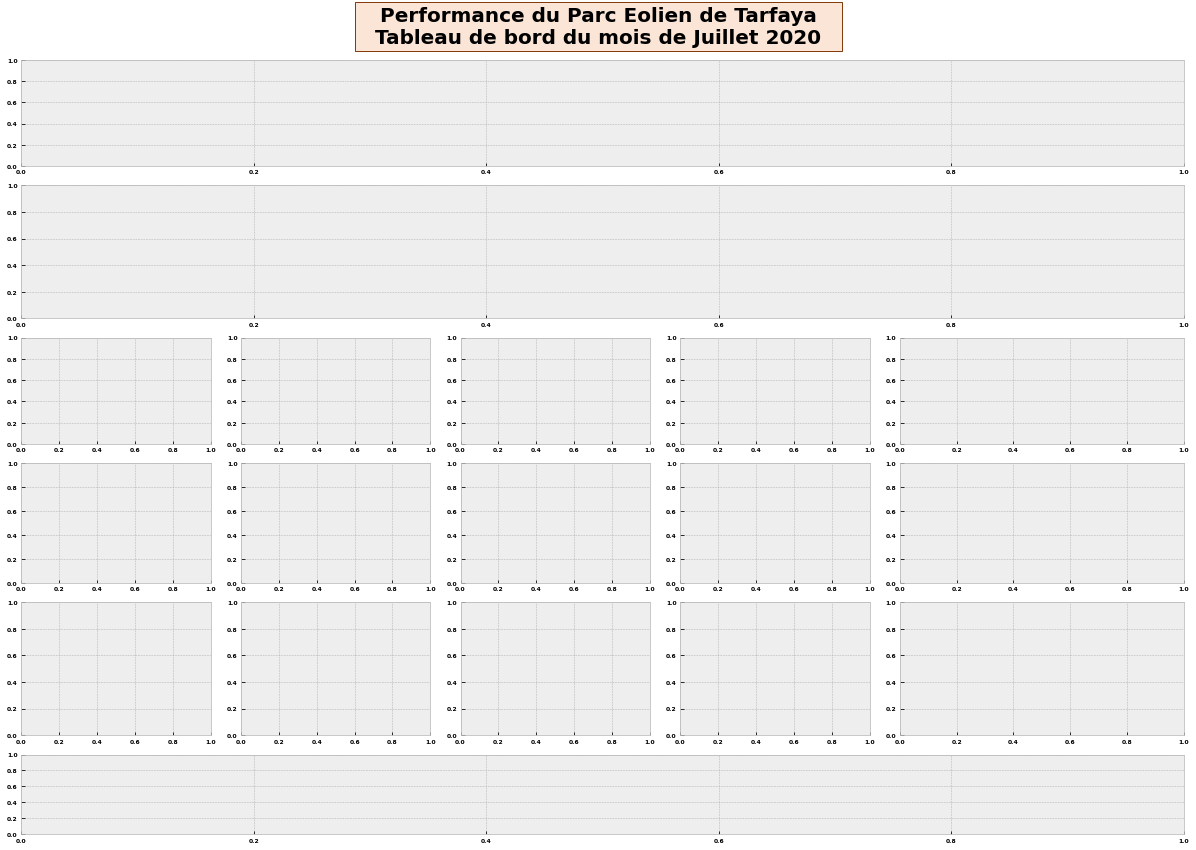

In [81]:
fig = plt.figure(constrained_layout=True, figsize=(22, 16))

# plt.rcParams.keys()
plt.rcParams['axes.labelsize'] = 7
plt.rcParams['xtick.labelsize'] = 6
plt.rcParams['ytick.labelsize'] = 6


heights = [0.8, 1, 0.8, 0.9, 1, 0.6]
widths = [1, 1, 1, 1, 1.5]
gs = fig.add_gridspec(6, 5, height_ratios=heights, width_ratios=widths,
                      wspace=0.05, hspace=0.05)


ax1 = fig.add_subplot(gs[0, :])
# ax1.set_title('gs[0, :]')

ax2 = fig.add_subplot(gs[1, :])

ax3 = fig.add_subplot(gs[2, 0])

ax4 = fig.add_subplot(gs[2, 1])

ax5 = fig.add_subplot(gs[2, 2])

ax6 = fig.add_subplot(gs[2, 3])

ax7 = fig.add_subplot(gs[2, 4])

ax8 = fig.add_subplot(gs[3, 0])

ax9 = fig.add_subplot(gs[3, 1])

ax10 = fig.add_subplot(gs[3, 2])

ax11 = fig.add_subplot(gs[3, 3])

ax12 = fig.add_subplot(gs[3, 4])

ax13 = fig.add_subplot(gs[4, 0])

ax14 = fig.add_subplot(gs[4, 1])

ax15 = fig.add_subplot(gs[4, 2])

ax16 = fig.add_subplot(gs[4, 3])

ax17 = fig.add_subplot(gs[4, 4])

ax18 = fig.add_subplot(gs[5, :])


fig.suptitle('   Performance du Parc Eolien de Tarfaya   \n Tableau de bord du mois de Juillet 2020 ',
             fontsize=20, fontweight='heavy', fontstretch='ultra-expanded',
             bbox=dict(facecolor='#fbe5d6', edgecolor='#843c0c', linewidth=1))

fig.set_size_inches(16.5, 11.7)
# plot_children(fig, fig._layoutbox, printit=False)
# fig

## Format axs

In [82]:
text_box_ticks = dict()

# for x in (ax1, ax2, ax7, ax12, ax13, ax14, ax15, ax16, ax17):
#     # x.set_yticks([]), x.set_xticks([])
#     x.set_axis_off()


# fig.patch.set_facecolor('grey')

ax2.patch.set_facecolor('#deebf7')  

ax4.tick_params(labelsize=8, rotation=90)
# ax4.secondary_yaxis('right')



## Add data to axs

In [83]:
plot_children(fig, fig._layoutbox, printit=False)

fig


NameError: name 'plot_children' is not defined

In [84]:
ax1.cla()
ax1.set_axis_off()
table1 = ax1.table(cellText=df_ax1.to_numpy().tolist(),
                   colLabels=df_ax1.columns.tolist(),
                   rowLabels=df_ax1.index.tolist(),
                   bbox = [0,0,1,0.7])


table1.auto_set_font_size(False)
table1.set_fontsize(7)
# table1.auto_set_column_width(col=list(range(len(df_ax1.columns))))
table1._cells[(1,-1)].set_width(0.1)
table1._cells[(2,-1)].set_width(0.1)

col_nmbrs = df_ax1.to_numpy().shape[1]

for i in range(-1, col_nmbrs):
    table1[(1,i)].set_facecolor('#fff2cc')
    table1[(2,i)].set_facecolor('#fbe5d6')


In [85]:
# for i in range(3,10):
#     eval(f'ax{i}.cla()')


df_ax3.plot(kind='bar', x='Error Group', ax=ax3, width=0.95, rot=75)
ax3.set_title('Cumul annuel par type d\'alarme',
                fontsize=8)

df_ax5.plot(kind='bar', x='Error Group', ax=ax5, width=0.95, rot=75)
ax5.set_title(f'Type d\'alarme {period}',
                fontsize=8)

df_ax6.plot(kind='bar', x='Alarmcode', ax=ax6, width=0.95)
ax6.set_title(f'Alarmes {period}',
                fontsize=8)

df_ax8.plot(kind='bar', x='StationId', ax=ax8, width=0.95)
ax8.set_title('Arrêts turbines : Cumul Annuel',
                fontsize=8)

df_ax9.plot(kind='bar', x='StationId', ax=ax9, width=0.95)
ax9.set_title(f'Arrêts turbines {period}',
                fontsize=8)


ax8.legend(ncol=2, fontsize=7)
ax9.legend(ncol=2, fontsize=7, frameon=True)




In [86]:
from matplotlib.ticker import ScalarFormatter

ax18.cla()
ax18.bar(df_ax18['StationId'].astype('str'), df_ax18['ELNX'], label='ELNX')
ax18.bar(df_ax18['StationId'].astype('str'), df_ax18['EL_indefini_left'], bottom=df_ax18['ELNX'],
       label='EL_indefini_left')

ax18.set_xlabel('StationId')
ax18.set_title('Energie perdue selon FSA cumulée sur l\'année 2020 en MWh',
                fontsize=8)
ax18.tick_params(axis='x', labelsize=6, rotation=90)
ax18.tick_params(axis='y', labelsize=5)

sf = ScalarFormatter(useMathText=True)
# sf.set_scientific(True)
sf.set_powerlimits((3, 3))
ax18.yaxis.set_major_formatter(sf)

ax18.yaxis.offsetText.set_fontsize(5)

ax18.legend(fontsize=7)

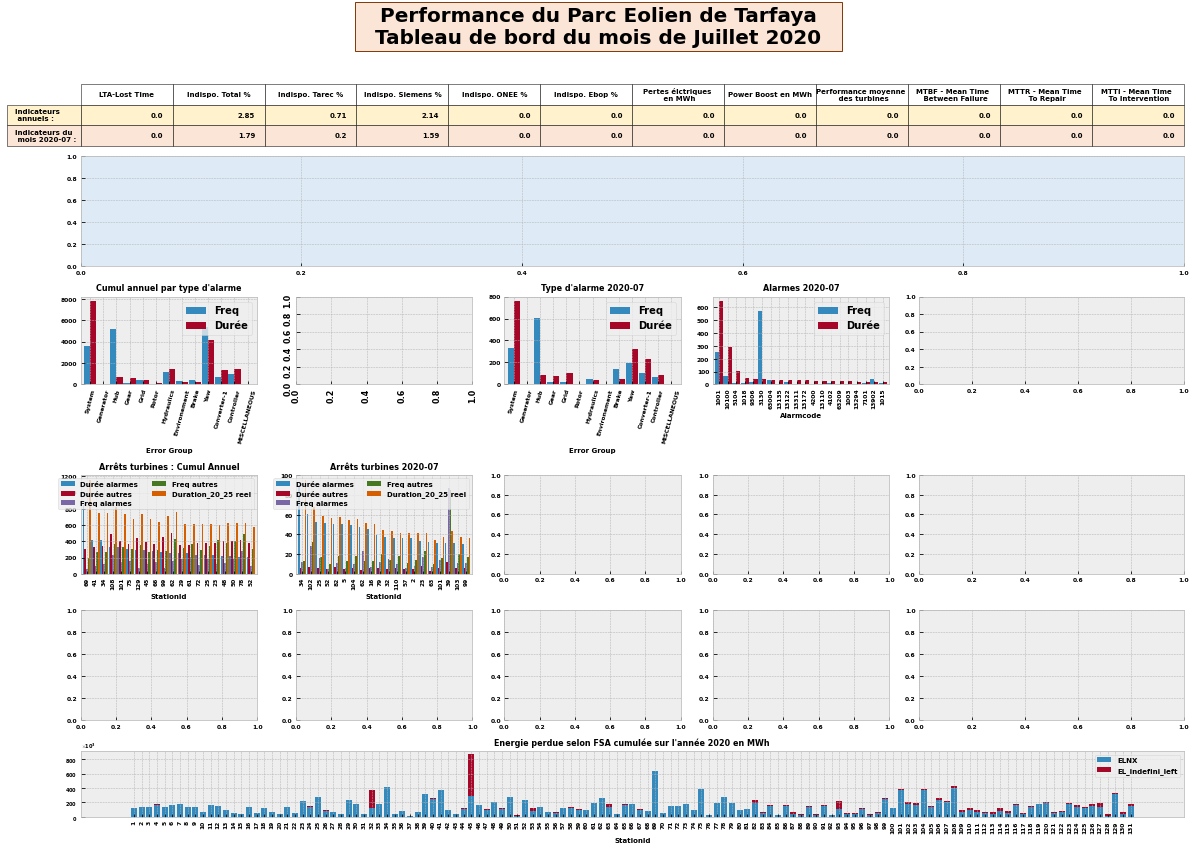

In [87]:
fig

In [88]:

for ax in [6, *range(11,17)]:

    eval(f'ax{ax+1}.set_axis_off()')

fig.draw(fig.canvas.get_renderer())

for ax in [6, *range(11,17)]:


    l,b,w,h =  (fig._layoutbox.children[0].children[ax].left.value(),
                fig._layoutbox.children[0].children[ax].bottom.value(),
                fig._layoutbox.children[0].children[ax].width.value(),
                fig._layoutbox.children[0].children[ax].height.value())

    # We can now make the rectangle in figure coords using the "transform" kwarg.
    rect = Rectangle((l, b), w, h,
                    facecolor='#f2f2f2', edgecolor='#843c0c', zorder=-1, 
                    transform=fig.transFigure, linewidth=1
                    )

    fig.patches.append(rect)

# plot_children(fig, fig._layoutbox, printit=False, level=3)

fig

NameError: name 'Rectangle' is not defined

In [89]:
fig.savefig('test.pdf', bbox_inches='tight', pad_inches=0.2)

In [90]:
plot_children(fig, fig._layoutbox, printit=False)
fig

NameError: name 'plot_children' is not defined

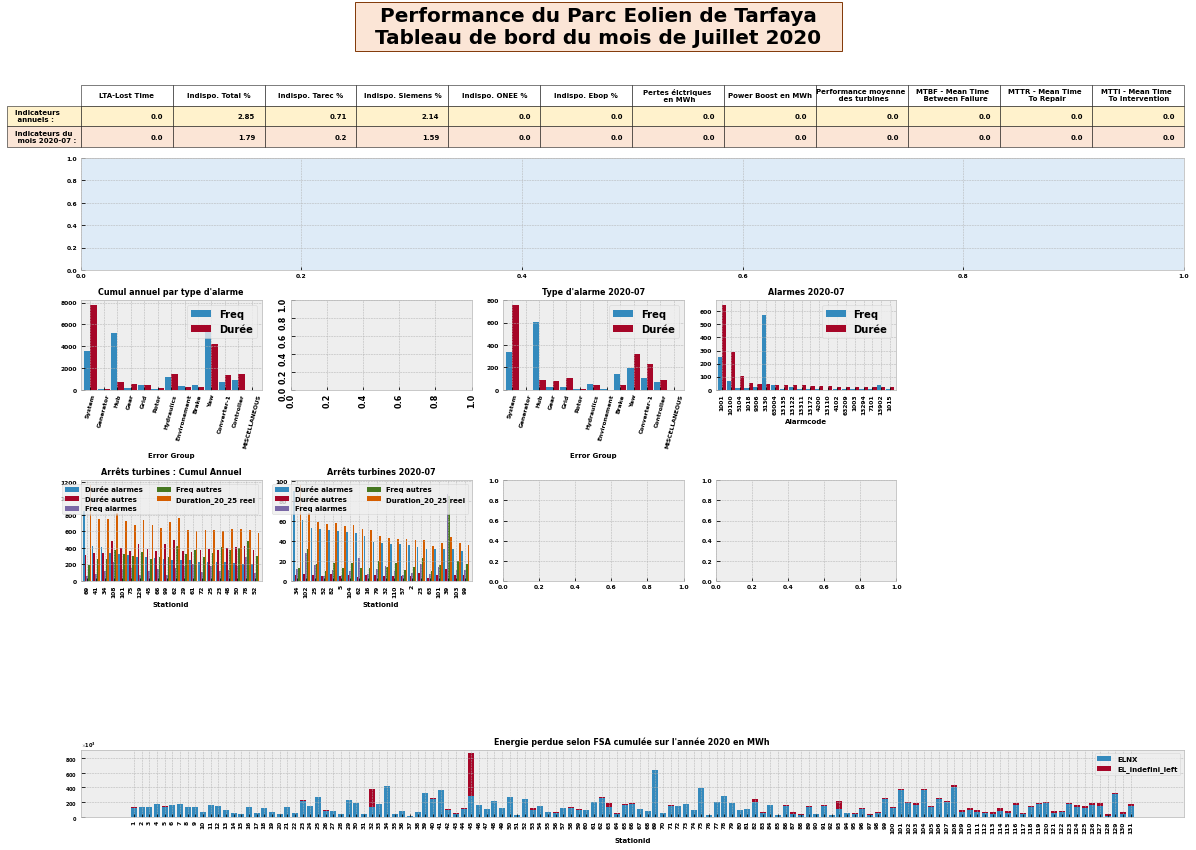

In [91]:
fig

# Export Data to excel xlsxwriter

In [92]:
writer = pd.ExcelWriter(f'./input/{period}/output_xlsxwriter.xlsx')
# -------------------------------------------------------------------------------------------

workbook = writer.book
dashsheet = workbook.add_worksheet('Dash')
# -------------------------------------------------------------------------------------------

df_ax1.to_excel(writer, index=False, sheet_name='ax1')

# -------------------------------------------------------------------------------------------

df_ax3.to_excel(writer, index=False, sheet_name='ax3')

worksheet = writer.sheets['ax3']


def make_chart_ax3():
    column_chart = workbook.add_chart({'type': 'column'})

    column_chart.add_series({'name': ['ax3', 0, 2],
                             'categories': ['ax3', 1, 0, 13, 0],
                             'values': ['ax3', 1, 2, 13, 2],})



    line_chart = workbook.add_chart({'type': 'line'})

    # Configure the data series for the secondary chart. We also set a
    # secondary Y axis via (y2_axis).
    line_chart.add_series({
        'values': ['ax3', 1, 1, 13, 1],
        'categories': ['ax3', 1, 0, 13, 0],
        'name': ['ax3', 0, 1],
        'y2_axis': True,
    })

    # Combine the charts.
    column_chart.combine(line_chart)

    # Configure the chart axes.
    # column_chart.set_x_axis({'name': df_ax3.columns[0]})
    column_chart.set_y_axis({'name': 'Durée en h'})
    column_chart.set_legend({'position': 'bottom'})
    column_chart.set_title({'name': 'Cumul annuel par type d\'alarme',
                            'name_font': {'size': 12, 'bold': True}})
    line_chart.set_y2_axis({'name': df_ax3.columns[1]})
    return column_chart


column_chart = make_chart_ax3()
# Insert the chart into the worksheet.
worksheet.insert_chart('E2', column_chart)

column_chart = make_chart_ax3()
# Insert the chart into the worksheet.
dashsheet.insert_chart('E42', column_chart)

# -------------------------------------------------------------------------------------------
df_ax4.to_excel(writer, index=False, sheet_name='ax4')
worksheet = writer.sheets['ax4']

def make_chart_ax4():
    column_chart = workbook.add_chart({'type': 'column'})

    column_chart.add_series({'name': ['ax4', 0, 2],
                             'categories': ['ax4', 1, 0, 13, 0],
                             'values': ['ax4', 1, 2, 13, 2]})

    line_chart = workbook.add_chart({'type': 'line'})

    # Configure the data series for the secondary chart. We also set a
    # secondary Y axis via (y2_axis).
    line_chart.add_series({
        'values': ['ax4', 1, 1, 13, 1],
        'categories': ['ax4', 1, 0, 13, 0],
        'name': ['ax4', 0, 1],
        'y2_axis': True,
    })
    

    # Combine the charts.
    column_chart.combine(line_chart)
    # Configure the chart axes.
    # column_chart.set_x_axis({'name': df_ax4.columns[0]})
    column_chart.set_y_axis({'name': 'MTBF en j'})
    column_chart.set_legend({'position': 'bottom'})
    column_chart.set_title({'name': 'MTBF et MTTR par catégorie sur l\'année 2020',
                            'name_font': {'size': 12, 'bold': True}})
    line_chart.set_y2_axis({'name': 'MTTR en h'})
    return column_chart


column_chart = make_chart_ax4()
# Insert the chart into the worksheet.
worksheet.insert_chart('E2', column_chart)

column_chart = make_chart_ax4()
# Insert the chart into the worksheet.
dashsheet.insert_chart('E42', column_chart)

# -------------------------------------------------------------------------------------------
df_ax5.to_excel(writer, index=False, sheet_name='ax5')

worksheet = writer.sheets['ax5']


def make_chart_ax5():
    column_chart = workbook.add_chart({'type': 'column'})

    column_chart.add_series({'name': ['ax5', 0, 2],
        'categories': ['ax5', 1, 0, 13, 0],
        'values': ['ax5', 1, 2, 13, 2]})

    line_chart = workbook.add_chart({'type': 'line'})

    # Configure the data series for the secondary chart. We also set a
    # secondary Y axis via (y2_axis).
    line_chart.add_series({
        'values': ['ax5', 1, 1, 13, 1],
        'categories': ['ax5', 1, 0, 13, 0],
        'name': ['ax5', 0, 1],
        'y2_axis': True,
    })
    

    # Combine the charts.
    column_chart.combine(line_chart)

    # Configure the chart axes.
    # column_chart.set_x_axis({'name': df_ax5.columns[0]})
    column_chart.set_y_axis({'name': 'Durée en h'})
    column_chart.set_legend({'position': 'bottom'})
    column_chart.set_title({'name': f'Type d\'alarme {period}',
                            'name_font': {'size': 12, 'bold': True}})

    line_chart.set_y2_axis({'name': df_ax5.columns[1]})
    return column_chart


# Insert the chart into the worksheet.
column_chart = make_chart_ax5()
# Insert the chart into the worksheet.
worksheet.insert_chart('E2', column_chart)

column_chart = make_chart_ax5()
# Insert the chart into the worksheet.
dashsheet.insert_chart('U42', column_chart)


# ------------------------------------------------------------------------------------------
df_ax6.to_excel(writer, index=False, sheet_name='ax6')

worksheet = writer.sheets['ax6']


def make_chart_ax6():
    column_chart = workbook.add_chart({'type': 'column'})

    column_chart.add_series({'name': ['ax6', 0, 2],
        'categories': ['ax6', 1, 0, 20, 0],
        'values': ['ax6', 1, 2, 20, 2]})

    line_chart = workbook.add_chart({'type': 'line'})

    # Configure the data series for the secondary chart. We also set a
    # secondary Y axis via (y2_axis).
    line_chart.add_series({
        'values': ['ax6', 1, 1, 20, 1],
        'categories': ['ax6', 1, 0, 20, 0],
        'name': ['ax6', 0, 1],
        'y2_axis': True,
    })

    # Combine the charts.
    column_chart.combine(line_chart)

    # Configure the chart axes.
    column_chart.set_x_axis({'name': df_ax6.columns[0]})
    column_chart.set_y_axis({'name': 'Durée en h'})
    column_chart.set_legend({'position': 'bottom'})
    column_chart.set_title({'name': f'Alarmes {period}',
                            'name_font': {'size': 12, 'bold': True}})

    line_chart.set_y2_axis({'name': df_ax6.columns[1]})
    return column_chart


# Insert the chart into the worksheet.
column_chart = make_chart_ax6()
# Insert the chart into the worksheet.
worksheet.insert_chart('E2', column_chart)

column_chart = make_chart_ax6()
# Insert the chart into the worksheet.
dashsheet.insert_chart('AC42', column_chart)


# ------------------------------------------------------------------------------------------------
df_ax8.to_excel(writer, index=False, sheet_name='ax8')

worksheet = writer.sheets['ax8']


def make_chart_ax8():
    column_chart = workbook.add_chart({'type': 'column',
                                        'subtype': 'stacked'})

    column_chart.add_series({'name': ['ax8', 0, 1],
        'categories': ['ax8', 1, 0, 20, 0],
        'values': ['ax8', 1, 1, 20, 1]})

    column_chart.add_series({'name': ['ax8', 0, 2],
        'categories': ['ax8', 1, 0, 20, 0],
        'values': ['ax8', 1, 2, 20, 2]})

    line_chart = workbook.add_chart({'type': 'line'})

    # Configure the data series for the secondary chart. We also set a
    # secondary Y axis via (y2_axis).
    line_chart.add_series({
        'values': ['ax8', 1, 3, 20, 3],
                             'categories': ['ax8', 1, 0, 20, 0],
                             'name': ['ax8', 0, 3],
        'y2_axis': True,
    })

    line_chart.add_series({
        'values': ['ax8', 1, 4, 20, 4],
                             'categories': ['ax8', 1, 0, 20, 0],
                             'name': ['ax8', 0, 4],
        'y2_axis': True,
    })

    # Combine the charts.
    column_chart.combine(line_chart)

    # Configure the chart axes.
    column_chart.set_x_axis({'name': df_ax8.columns[0]})
    column_chart.set_y_axis({'name': 'Durée en h'})
    column_chart.set_legend({'position': 'bottom'})
    column_chart.set_title({'name': 'Arrêts turbines : Cumul Annuel',
                            'name_font': {'size': 12, 'bold': True}})

    line_chart.set_y2_axis({'name': 'Freq'})
    return column_chart


# Insert the chart into the worksheet.
column_chart = make_chart_ax8()
# Insert the chart into the worksheet.
worksheet.insert_chart('G2', column_chart)

column_chart = make_chart_ax8()
# Insert the chart into the worksheet.
dashsheet.insert_chart('E58', column_chart)


# ----------------------------------------------------------------------------------------
# --------
df_ax9.to_excel(writer, index=False, sheet_name='ax9')

worksheet = writer.sheets['ax9']


def make_chart_ax9():
    column_chart = workbook.add_chart({'type': 'column',
                                       'subtype': 'stacked'})

    column_chart.add_series({'name': ['ax9', 0, 1],
        'categories': ['ax9', 1, 0, 20, 0],
        'values': ['ax9', 1, 1, 20, 1]})

    column_chart.add_series({'name': ['ax9', 0, 2],
        'categories': ['ax9', 1, 0, 20, 0],
        'values': ['ax9', 1, 2, 20, 2]})

    line_chart = workbook.add_chart({'type': 'line'})

    # Configure the data series for the secondary chart. We also set a
    # secondary Y axis via (y2_axis).
    line_chart.add_series({
        'values': ['ax9', 1, 3, 20, 3],
                             'categories': ['ax9', 1, 0, 20, 0],
                             'name': ['ax9', 0, 3],
        'y2_axis': True,
    })

    line_chart.add_series({
        'values': ['ax9', 1, 4, 20, 4],
                             'categories': ['ax9', 1, 0, 20, 0],
                             'name': ['ax9', 0, 4],
        'y2_axis': True,
    })

    # Combine the charts.
    column_chart.combine(line_chart)

    # Configure the chart axes.
    column_chart.set_x_axis({'name': df_ax9.columns[0]})
    column_chart.set_y_axis({'name': 'Durée en h'})
    column_chart.set_legend({'position': 'bottom'})
    column_chart.set_title({'name': f'Arrêts turbines {period}',
                            'name_font': {'size': 12, 'bold': True}})

    line_chart.set_y2_axis({'name': 'Freq'})
    return column_chart


# Insert the chart into the worksheet.
column_chart = make_chart_ax9()
# Insert the chart into the worksheet.
worksheet.insert_chart('G2', column_chart)

column_chart = make_chart_ax9()
# Insert the chart into the worksheet.
dashsheet.insert_chart('M58', column_chart)

# ----------------------------------------------------------------------------------------
df_ax10.to_excel(writer, index=False, sheet_name='ax10')

worksheet = writer.sheets['ax10']


def make_chart_ax10():
    column_chart = workbook.add_chart({'type': 'column',
                                       'subtype': 'stacked'})

    for col in range(1, 3):
        column_chart.add_series({'values': ['ax10', 1, col, 20, col],
                                 'categories': ['ax10', 1, 0, 20, 0],
                                 'name': ['ax10', 0, col]})

    # Configure the chart axes.
    column_chart.set_x_axis({'name': df_ax10.columns[0]})
    # column_chart.set_y_axis({'name': df_ax10.columns[1]})
    column_chart.set_legend({'position': 'bottom'})
    column_chart.set_title(
        {'name': f'Energie perdue selon FSA du {period}',
         'name_font': {'size': 12, 'bold': True}}
    )
    return column_chart


# Insert the chart into the worksheet.
column_chart = make_chart_ax10()
# Insert the chart into the worksheet.
worksheet.insert_chart('E2', column_chart)

column_chart = make_chart_ax10()
# Insert the chart into the worksheet.
dashsheet.insert_chart('U58', column_chart)

# ----------------------------------------------------------------------------------------
df_ax18.to_excel(writer, index=False, sheet_name='ax18')

worksheet = writer.sheets['ax18']


def make_chart_ax18():
    column_chart = workbook.add_chart({'type': 'column',
                                       'subtype': 'stacked'})

    for col in range(1, 3):
        column_chart.add_series({'values': ['ax18', 1, col, 131, col],
                                 'categories': ['ax18', 1, 0, 131, 0],
                                 'name': ['ax18', 0, col]})

    # Configure the chart axes.
    column_chart.set_x_axis({'name': df_ax18.columns[0]})
    # column_chart.set_y_axis({'name': df_ax18.columns[1]})
    column_chart.set_legend({'position': 'bottom'})
    column_chart.set_title(
        {'name': 'Energie perdue selon FSA cumulée sur l\'année 2020 en MWh',
         'name_font': {'size': 12, 'bold': True}}
    )
    return column_chart


# Insert the chart into the worksheet.
column_chart = make_chart_ax18()
# Insert the chart into the worksheet.
worksheet.insert_chart('E2', column_chart)

column_chart = make_chart_ax18()
# Insert the chart into the worksheet.
dashsheet.insert_chart('U58', column_chart)

# ----------------------------------------------------------------------------------------
df_ax19.to_excel(writer, index=False, sheet_name='ax19')

worksheet = writer.sheets['ax19']


def make_chart_ax19():
    column_chart = workbook.add_chart({'type': 'column'})

    column_chart.add_series({'values': ['ax19', 1, 1, 131, 1],
                             'categories': ['ax19', 1, 0, 131, 0],
                             'name': ['ax19', 0, 1]})

    # Configure the chart axes.
    column_chart.set_x_axis({'name': df_ax19.columns[0]})
    # column_chart.set_y_axis({'name': df_ax19.columns[1]})
    column_chart.set_legend({'position': 'bottom'})
    column_chart.set_title(
        {'name': f'Ratio Courbe Théorique vs Courbe Réelle du {period}',
         'name_font': {'size': 12, 'bold': True}}
    )
    return column_chart


# Insert the chart into the worksheet.
column_chart = make_chart_ax19()
# Insert the chart into the worksheet.
worksheet.insert_chart('E2', column_chart)

column_chart = make_chart_ax19()
# Insert the chart into the worksheet.
dashsheet.insert_chart('U58', column_chart)


writer.save()

NameError: name 'df_ax19' is not defined

# Report lab

In [93]:
from reportlab.pdfgen import canvas
from reportlab.lib import pdfencrypt
from reportlab.lib import colors
from reportlab.lib.units import inch
from reportlab.lib.pagesizes import landscape, A3
from reportlab.pdfbase.pdfmetrics import stringWidth



In [94]:
pdf = canvas.Canvas('home.pdf', pagesize=landscape(A3), bottomup=0,
                    verbosity=1)
# pdf.translate(inch, inch)

pdf.saveState()
pdf.setStrokeColorRGB(132/255, 60/255, 12/255)
pdf.setFillColorRGB(251/255, 229/255, 214/255)
PAGE_WIDTH = pdf._pagesize[0]/72

#------------------------------------------------------------------------
title = 'Performance du Parc Eolien de Tarfaya \n Tableau de bord du mois de Juillet 2020'
title_width = stringWidth(title, 'Helvetica-Bold', 15)
pdf.setFont('Helvetica-Bold', 15)
# center rectangle on x
width = title_width/72 + 0.1 # inches
x = PAGE_WIDTH/2 - width/2 # inches
y = 0.16
height = 0.7
pdf.rect(x*inch, y*inch, width*inch, height*inch, fill=1)

x_string = PAGE_WIDTH/2 - title_width/72/2
y_string = height/2 + y

pdf.setFillColorRGB(0,0,0)
pdf.drawCentredString(PAGE_WIDTH/2*inch, y_string*inch, title)

#------------------------------------------------------------------------
pdf.setFillColorRGB(255/255, 242/255, 204/255)
# center rectangle on x
width = 14 # inches
x = PAGE_WIDTH/2 - width/2 # points

pad = 0.1
y = y + height + pad
height = 1
pdf.rect(x*inch, y*inch, width*inch, height*inch, fill=1)
#------------------------------------------------------------------------
pdf.setFillColorRGB(251/255, 229/255, 214/255)
pad = 0.08
y = y + height + pad
height = 1
pdf.rect(x*inch, y*inch, width*inch, height*inch, fill=1)

#------------------------------------------------------------------------
pdf.setFillColorRGB(222/255, 235/255, 247/255)

width = 15 # inches
x = PAGE_WIDTH/2 - width/2 # points
pad = 0.12
y = y + height + pad
height = 1.3
pdf.rect(x*inch, y*inch, width*inch, height*inch, fill=1)

pdf.save()

saved home.pdf


In [95]:
from reportlab.pdfgen import canvas
from reportlab.pdfbase import pdfmetrics
canv = canvas.Canvas('sizetest.pdf', bottomup=0)
fontname = 'Helvetica'
fontsize = 8

face = pdfmetrics.getFont(fontname).face
ascent = (face.ascent * fontsize) / 1000.0
descent = (face.descent * fontsize) / 1000.0

height = ascent - descent # <-- descent it's negative

#draw a box 10 wide and "height" tall
canv.rect(50, 10, 60, height) # <--to keep the baseline at 600

#Write the string next to the box, it should be the exact same height
canv.setFont(fontname, fontsize) # <-- fix the size of your output text
canv.drawString(62,10 + height,'Testing')

canv.save()

height/72

0.10277777777777777

In [96]:
(ascent,
descent,
height)

(5.744, -1.656, 7.3999999999999995)

In [97]:
from reportlab.lib.styles import getSampleStyleSheet, ParagraphStyle
from reportlab.lib.pagesizes import letter
from reportlab.platypus import Paragraph, SimpleDocTemplate, Flowable, Spacer
from reportlab.graphics.shapes import Drawing, Rect

my_doc = SimpleDocTemplate('myfile.pdf', pagesize=landscape(A3), buttomup=0)
flowables = []
my_doc.build(flowables)
styles = getSampleStyleSheet()

paragraph_1 = Paragraph("A litle bit of this", styles['Heading1'])
paragraph_2 = Paragraph('Some normal body text', styles['BodyText'])

flowables.extend([paragraph_1, paragraph_2])

my_doc.build(flowables)

In [98]:
styles['BodyText']

<ParagraphStyle 'BodyText'>

# export to excel openpyxl

In [99]:
from openpyxl import load_workbook
wb = load_workbook(filename=f'./input/{period}/output_xlsxwriter.xlsx')

In [100]:
wb.save(filename = f'./input/{period}/openpyxl_test.xlsx')

# df ax 19

In [101]:
import pandas as pd

In [102]:
df_ax19 = pd.read_html(f'./input/{period}/TAREC REPORTING.html', thousands=' ', decimal=',')[0]

df_ax19['Turbine'] = df_ax19['Turbine'].str.extract(r'\[[^\d]*(\d+)[^\d]*\]').values.astype(int)

In [103]:
df_ax19 = df_ax19[['Turbine', 'Ratio']]

In [104]:
df_ax19.Ratio.mean()

105.1226717557252

In [105]:
(94.846*182 + 105.12*31)/(31+182)

96.34127699530518

# ax_7

In [117]:
most_categories = main_result_sum.groupby('Error Group').agg({'RealPeriod': np.sum}).sort_values('RealPeriod').tail(4).index.values
df_most_categories = main_result_sum.loc[main_result_sum['Error Group'].isin(most_categories)]
df_most_categories

,TimeOn,TimeOff,StationId,Alarmcode,ID,Parameter,UK Text,Error Type,Error Group,NewTimeOn,RealPeriod,Period Siemens(s),Period Tarec(s)
0,2020-07-02 08:57:20.999,2020-07-02 15:33:49.000,1,1001,3034936,...,Manual stop,1,System,2020-07-02 08:57:20.999,06:36:28.001000,06:36:28.001000,NaT
21,2020-07-06 08:11:10.000,2020-07-06 15:18:53.999,1,1001,3040484,...,Manual stop,1,System,2020-07-06 08:11:10.000,07:07:43.999000,07:07:43.999000,NaT
55,2020-07-07 08:25:01.000,2020-07-07 12:19:34.000,1,1001,3045631,...,Manual stop,1,System,2020-07-07 08:25:01.000,03:54:33,03:54:33,NaT
72,2020-07-07 12:20:11.000,2020-07-07 12:21:37.000,1,1140,3046716,...,"Tower vibration, waiting",1,System,2020-07-07 12:20:11.000,00:01:26,00:01:26,NaT
73,2020-07-07 12:20:49.000,2020-07-07 15:32:41.000,1,1001,3046717,...,Manual stop,1,System,2020-07-07 12:21:37.000,03:11:04,03:11:04,NaT
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4892,2020-07-26 06:11:56.000,2020-07-26 06:12:57.000,129,13902,3074953,...,"Converter tripped, Auto Start",1,Converter-1,2020-07-26 06:11:56.000,00:01:01,00:01:01,NaT
4893,2020-07-26 06:11:56.000,2020-07-26 06:26:00.999,129,13122,3074955,...,Grd. Inv. Communication error,1,Converter-1,2020-07-26 06:12:57.000,00:13:03.999000,00:13:03.999000,NaT
4911,2020-07-21 14:59:10.999,2020-07-21 15:20:05.000,131,1001,3069270,...,Manual stop,1,System,2020-07-21 15:06:40.999,00:13:24.001000,00:13:24.001000,NaT
4915,2020-07-22 08:30:32.999,2020-07-22 14:42:45.999,131,1001,3070019,...,Manual stop,1,System,2020-07-22 11:02:36.000,03:40:09.999000,03:40:09.999000,NaT


In [118]:
def extract_important_alarms(df):

    df = df.groupby('Alarmcode').agg({'RealPeriod': np.sum}).reset_index()
    df['percentage'] = 100 * df['RealPeriod'] / df['RealPeriod'].sum()
    df.sort_values('percentage', ascending=False, inplace=True)
    df['percentage roll'] = df['percentage'].cumsum()

    for i in range(1,100):
        if len(df.query('`percentage roll` < @i')) < 3:
            continue
        elif
        df = df.query('`percentage roll` < @i')
        break

    return df

SyntaxError: invalid syntax (<ipython-input-118-a4dcc24100d1>, line 11)

In [119]:
df = df_most_categories.query('`Error Group` == "Converter-1"')

df = df.groupby('Alarmcode').agg({'RealPeriod': np.sum}).reset_index()
df['percentage'] = 100 * df['RealPeriod'] / df['RealPeriod'].sum()
df.sort_values('percentage', ascending=False, inplace=True)
df.reset_index(inplace=True, drop=True)
df['percentage roll'] = df['percentage'].cumsum()
df

,Alarmcode,RealPeriod,percentage,percentage roll
0,13135,1 days 10:55:23.001000,14.997660,14.997660
1,13122,1 days 10:27:52.002000,14.800710,29.798369
2,13311,1 days 09:01:36.999000,14.183377,43.981746
3,13172,1 days 07:53:28,13.695595,57.677341
4,13110,1 days 02:35:30,11.419756,69.097097
5,13294,0 days 21:09:22.001000,9.085464,78.182561
6,13902,0 days 19:26:42.999000,8.350748,86.533309
7,13107,0 days 19:05:51.136000,8.201412,94.734721
8,13216,0 days 12:02:13.999000,5.169369,99.904090
9,13900,0 days 00:10:02,0.071813,99.975903


In [120]:
df_ax7 = (df_most_categories.groupby('Error Group')
                             .apply(lambda x: extract_important_alarms(x))
                             .reset_index()
                             .merge(error_list[['UK Text', 'Alarmcode']]))

df_ax7

NameError: name 'extract_important_alarms' is not defined

In [121]:
df_ax7 = (df_most_categories.groupby('Error Group')
                             .apply(lambda x: (x.groupby('Alarmcode')
                                                .agg({'RealPeriod': np.sum})
                                                .sort_values('RealPeriod')
                                                .tail(4)))
                             .reset_index()
                             .merge(error_list[['UK Text', 'Alarmcode']]))

df_ax7

,Error Group,Alarmcode,RealPeriod,UK Text
0,Converter-1,13172,1 days 07:53:28,Grid filter RES temp. error
1,Converter-1,13311,1 days 09:01:36.999000,Inv.(tow) coolwater pres. low
2,Converter-1,13122,1 days 10:27:52.002000,Grd. Inv. Communication error
3,Converter-1,13135,1 days 10:55:23.001000,"Fuse blown, Grid filter"
4,Grid,5112,0 days 00:00:02,Gridvolt.<lower limit3
5,Grid,5110,0 days 00:00:16.005000,Gridvolt.<lower limit1
6,Grid,5111,0 days 00:00:18,Gridvolt.<lower limit2
7,Grid,5104,4 days 07:40:15.997000,Low lower voltage exceeded
8,System,1015,0 days 19:22:03,Manual idle stop
9,System,1003,0 days 22:26:17.002000,Emergency switch activated


In [122]:
ax_7 = '''

Les alarmes "System" les plus importantes sont 
    - "1001 - Manual Stop"  afin de permettre les travaux curatifs SGRE.
    - "1007 - Remote Stop Owner" elle a été activée afin de permettre l'entretien des PPDMs.

Les arrêts "hub" " sont causés par
    - "3130 - pitch lubrification".

Les arrêts "Yaw" sont liés aux alarmes
    - "10100 - Yaw motor superhearted" et
    - "10401 - yaw fail stopped"

Les arrêts "Controller" sont déclanchés à cause du déchargement des UPS dans
les turbines.

Le MTBF le moins bon du mois est celui de la catégorie "Yaw" :  126 jours
'''

# Power Boost

In [123]:
def read_boost(file_name):
    usecols_cnt = '''TimeStamp, StationId, wtc_BoostKWh_endvalue'''

    sql_cnt = f"Select {usecols_cnt} FROM tblSCTurCount;"

    cnt = mdb_to_df(file_name=file_name, sql=sql_cnt)

    cnt['TimeStamp'] = pd.to_datetime(
        cnt['TimeStamp'], format='%m/%d/%y %H:%M:%S')

    return cnt


In [124]:
m = str(period_month).zfill(2)
file_name = f'../Availability_Warranty_Dash/monthly_data/uploads/2020-{m}/2020-{m}-cnt.mdb' 
boost = read_boost(file_name)

DRIVER={Microsoft Access Driver (*.mdb, *.accdb)};DBQ=../Availability_Warranty_Dash/monthly_data/uploads/2020-07/2020-07-cnt.mdb;
../Availability_Warranty_Dash/monthly_data/uploads/2020-07/2020-07-cnt.mdb Loaded


In [125]:
df_ax1.iat[1, 7] = (boost.groupby('TimeStamp').sum().iat[-1, -1] - boost.groupby('TimeStamp').sum().iat[0, 1])/1000

In [126]:
(boost.groupby('TimeStamp').sum().iat[-1, -1] - boost.groupby('TimeStamp').sum().iat[0, 1])/1000

2727.123853515625

In [127]:
boost.groupby('TimeStamp').sum().iat[0, 1]

24033896.802734375

In [128]:
(boost.groupby('TimeStamp').sum().iat[-1, -1] - boost.groupby('TimeStamp').sum().iat[0, 1])/1000

2727.123853515625

In [129]:
boost.query('wtc_BoostKWh_endvalue == 9851.900391')

,TimeStamp,StationId,wtc_BoostKWh_endvalue


In [130]:
boost.query('StationId == 2307436')

,TimeStamp,StationId,wtc_BoostKWh_endvalue
31,2020-07-01 00:00:00,2307436,211776.593750
162,2020-07-01 00:10:00,2307436,211784.703125
293,2020-07-01 00:20:00,2307436,211784.703125
424,2020-07-01 00:30:00,2307436,211784.703125
555,2020-07-01 00:40:00,2307436,211784.703125
...,...,...,...
582839,2020-07-31 23:20:00,2307436,9851.900391
582970,2020-07-31 23:30:00,2307436,9851.900391
583101,2020-07-31 23:40:00,2307436,9851.900391
583232,2020-07-31 23:50:00,2307436,9851.900391


In [131]:
# unecessary just add last cumulated value to this period value
boost_cumul = pd.DataFrame()
for i in range(1,8):
    m = str(i).zfill(2)
    file_name = f'../Availability_Warranty_Dash/monthly_data/uploads/2020-{m}/2020-{m}-cnt.mdb' 
    
    boost = read_boost(file_name)
    boost_cumul = pd.concat([boost_cumul, boost])

DRIVER={Microsoft Access Driver (*.mdb, *.accdb)};DBQ=../Availability_Warranty_Dash/monthly_data/uploads/2020-01/2020-01-cnt.mdb;
../Availability_Warranty_Dash/monthly_data/uploads/2020-01/2020-01-cnt.mdb Loaded
DRIVER={Microsoft Access Driver (*.mdb, *.accdb)};DBQ=../Availability_Warranty_Dash/monthly_data/uploads/2020-02/2020-02-cnt.mdb;
../Availability_Warranty_Dash/monthly_data/uploads/2020-02/2020-02-cnt.mdb Loaded
DRIVER={Microsoft Access Driver (*.mdb, *.accdb)};DBQ=../Availability_Warranty_Dash/monthly_data/uploads/2020-03/2020-03-cnt.mdb;
../Availability_Warranty_Dash/monthly_data/uploads/2020-03/2020-03-cnt.mdb Loaded
DRIVER={Microsoft Access Driver (*.mdb, *.accdb)};DBQ=../Availability_Warranty_Dash/monthly_data/uploads/2020-04/2020-04-cnt.mdb;
../Availability_Warranty_Dash/monthly_data/uploads/2020-04/2020-04-cnt.mdb Loaded
DRIVER={Microsoft Access Driver (*.mdb, *.accdb)};DBQ=../Availability_Warranty_Dash/monthly_data/uploads/2020-05/2020-05-cnt.mdb;
../Availability_Warran

In [132]:
df_ax1.iat[0, 7] = (boost_cumul.groupby('TimeStamp').sum().iat[-1, -1] - boost_cumul.groupby('TimeStamp').sum().iat[0, 1])/1000

In [133]:
df_ax1

,LTA-Lost Time,Indispo. Total %,Indispo. Tarec %,Indispo. Siemens %,Indispo. ONEE %,Indispo. Ebop %,Pertes élctriques \n en MWh,Power Boost en MWh,Performance moyenne \n des turbines,MTBF - Mean Time \n Between Failure,MTTR - Mean Time \n To Repair,MTTI - Mean Time \n To Intervention
Indicateurs \n annuels :,0.0,2.85,0.71,2.14,0.0,0.0,0.0,6188.737721,0.0,0.0,0.0,0.0
Indicateurs du \n mois 2020-07 :,0.0,1.79,0.20,1.59,0.0,0.0,0.0,2727.123854,0.0,0.0,0.0,0.0


In [134]:
df

,Alarmcode,RealPeriod,percentage,percentage roll
0,13135,1 days 10:55:23.001000,14.997660,14.997660
1,13122,1 days 10:27:52.002000,14.800710,29.798369
2,13311,1 days 09:01:36.999000,14.183377,43.981746
3,13172,1 days 07:53:28,13.695595,57.677341
4,13110,1 days 02:35:30,11.419756,69.097097
5,13294,0 days 21:09:22.001000,9.085464,78.182561
6,13902,0 days 19:26:42.999000,8.350748,86.533309
7,13107,0 days 19:05:51.136000,8.201412,94.734721
8,13216,0 days 12:02:13.999000,5.169369,99.904090
9,13900,0 days 00:10:02,0.071813,99.975903
